In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import os
import sys 
import statsmodels as sm
import statsmodels.api as smapi
import statsmodels.regression.linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
from fbprophet import Prophet
import logging
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report
logging.getLogger().setLevel(logging.ERROR)
sys.path.append(os.path.abspath("../../"))
import Utilities as utils
import Constants as c
%matplotlib inline

In [3]:
project_name = "angular.js"
directoryPath = "../../exports"
task = "BUG"
bugs = "{directoryPath}/{project_name}/{project_name}_dataset_{task}.csv".format(directoryPath=directoryPath, project_name=project_name, task=task)

cc_columns = [c.VERSION, c.DATE, c.NT_CC, c.NO_CC, c.MODULE_CC, c.LINE_CC, c.T_MODULE, c.T_LINE, c.T_CC]
df = pd.read_csv(bugs, usecols = cc_columns)
df = df.dropna(subset=[c.T_MODULE])
df = df.dropna(subset=[c.DATE])
df[c.DATE] = pd.to_datetime(df[c.DATE])
df = df.set_index(c.DATE)
df.index = df.index.strftime('%Y-%m-%d') 
if df.isna().values.any():
    df.fillna(0, inplace=True)

df.head()

# df = utils.remove_outlier(df, c.LINE_CC)
# df = utils.remove_outlier(df, c.MODULE_CC)
# df = df[df.Version.str.contains(r"^[v]{0,1}\d{1,2}\.\d{1,2}\.\d{1,2}[\.\d{1,2}]{0,2}$", regex=True, na=False)]
# df.head()

,Version,T_Module,T_Line,NT_CC,NO_CC,Module_CC,Line_CC,T_CC
Date,,,,,,,,
2010-10-26,v0.9.1,162.0,26365.0,20.0,46.0,176.0,6262.0,2.0
2010-11-03,v0.9.2,185.0,30279.0,13.0,47.0,51.0,860.0,2.0
2010-11-10,v0.9.3,193.0,31992.0,6.0,75.0,16.0,86.0,2.0
2010-11-18,v0.9.4,200.0,34257.0,18.0,72.0,24.0,858.0,1.0
2010-11-25,v0.9.5,200.0,35422.0,2.0,58.0,4.0,26.0,1.0


In [4]:
# df.describe()
# df.dtypes

In [5]:
# display correlation matrix
display(df.corr())

,T_Module,T_Line,NT_CC,NO_CC,Module_CC,Line_CC,T_CC
T_Module,1.000000,0.965995,0.202470,0.201206,0.184358,0.198644,0.159070
T_Line,0.965995,1.000000,0.162341,0.155448,0.133572,0.131840,0.058556
NT_CC,0.202470,0.162341,1.000000,0.989097,0.967230,0.877327,0.795761
NO_CC,0.201206,0.155448,0.989097,1.000000,0.959056,0.861121,0.800962
Module_CC,0.184358,0.133572,0.967230,0.959056,1.000000,0.952415,0.756049
Line_CC,0.198644,0.131840,0.877327,0.861121,0.952415,1.000000,0.708470
T_CC,0.159070,0.058556,0.795761,0.800962,0.756049,0.708470,1.000000


In [6]:
# sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')

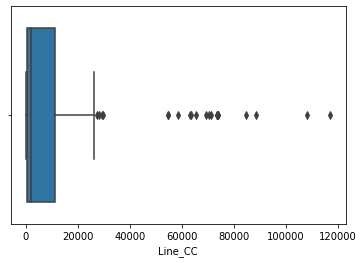

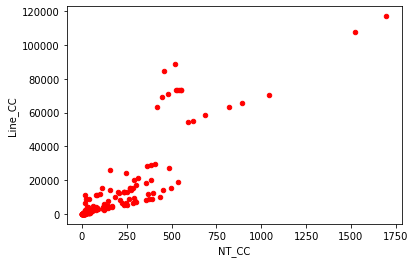

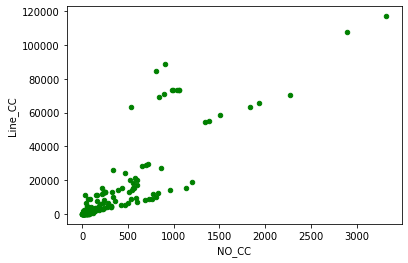

In [7]:
sns.boxplot(x=df[c.LINE_CC])
df.plot.scatter(x=c.NT_CC, y=c.LINE_CC, c='red')
df.plot.scatter(x=c.NO_CC, y=c.LINE_CC, c='green')


In [8]:
# Let's create multiple regression
X = df[[c.NT_CC, c.NO_CC]]
Y = df[c.LINE_CC]
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.75, test_size=0.25, random_state=0)

model = lm.OLS(y_train, X_train).fit()
predictions = model.predict(X_test)
 
print_model = model.summary()
print(print_model)
# Interpreting Restuls:  https://www.youtube.com/watch?v=U7D1h5bbpcs  

OLS Regression Results                                
Dep. Variable:                Line_CC   R-squared (uncentered):                   0.801
Model:                            OLS   Adj. R-squared (uncentered):              0.798
Method:                 Least Squares   F-statistic:                              291.0
Date:                Thu, 30 Apr 2020   Prob (F-statistic):                    1.74e-51
Time:                        22:38:49   Log-Likelihood:                         -1569.7
No. Observations:                 147   AIC:                                      3143.
Df Residuals:                     145   BIC:                                      3149.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

In [9]:
data = {c.OBSERVED:y_test, c.PREDICTED:predictions.round(2), c.DIFFERENCE:abs(y_test - predictions).round(2), c.PERCENT_ERROR:(abs(y_test - predictions)/y_test).round(2)}
results = pd.DataFrame(data) 
results[c.VERSION] = np.arange(results.__len__())
# results

In [10]:
print("{0} - {1} - {2} model performance: ".format(project_name, task, c.MODULE_CC))
print(utils.format_perf_metric('Model - R Squared', model.rsquared))
print(utils.format_perf_metric('Model - R Squared Adj', model.rsquared_adj))
print(utils.format_perf_metric('Pred - Mean Absolute Error', metrics.mean_absolute_error(y_test, predictions)))
print(utils.format_perf_metric('Pred - Mean Squared Error', metrics.mean_squared_error(y_test, predictions)))
print(utils.format_perf_metric('Pred - Root Mean Squared Error', np.sqrt(metrics.mean_squared_error(y_test, predictions))))
pred25 = utils.calculate_PRED(0.25, results)
print(utils.format_PRED("25", pred25))
pred50 = utils.calculate_PRED(0.50, results)
print(utils.format_PRED("50", pred50))

angular.js - BUG - Module_CC model performance: 
Model - R Squared: 0.8
Model - R Squared Adj: 0.8
Pred - Mean Absolute Error: 5485.73
Pred - Mean Squared Error: 101255410.89
Pred - Root Mean Squared Error: 10062.57
Pred - PRED (25): 16.33%
Pred - PRED (50): 32.65%


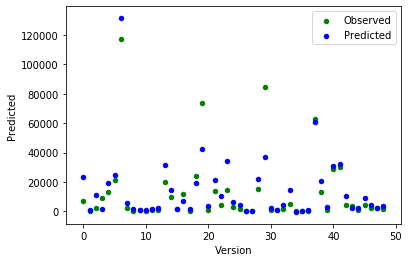

In [11]:
ax = results.plot(kind='scatter', x=c.VERSION, y=c.OBSERVED, c='green', label=c.OBSERVED)
results.plot(kind='scatter', x=c.VERSION, y=c.PREDICTED, c='blue', label=c.PREDICTED, ax=ax)

In [12]:
# partialRegPlot = plt.figure(figsize=(15,8))
# partialRegPlot = sm.graphics.regressionplots.plot_partregress_grid(model, fig=partialRegPlot)

In [13]:
# regPlotNC = plt.figure(figsize=(15,8))
# regPlotNC = sm.graphics.regressionplots.plot_regress_exog(model, c.NT_CC, fig=regPlotNC)

In [14]:
# regPlotNO = plt.figure(figsize=(15,8))
# regPlotNO = sm.graphics.regressionplots.plot_regress_exog(model, c.NO_CC, fig=regPlotNO)

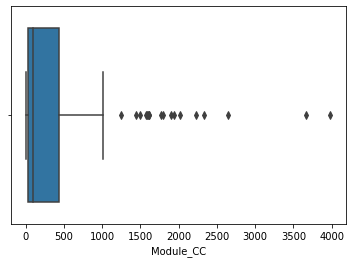

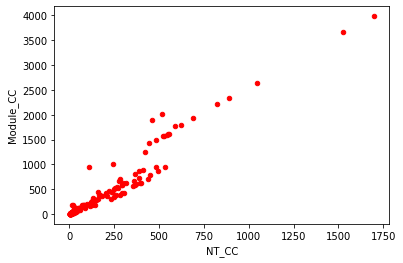

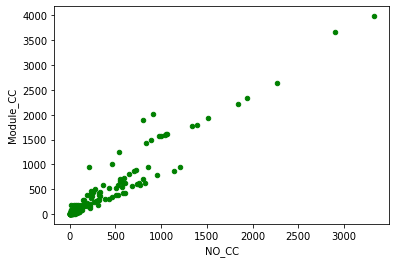

In [15]:
sns.boxplot(x=df[c.MODULE_CC])
df.plot.scatter(x=c.NT_CC, y=c.MODULE_CC, c='red')
df.plot.scatter(x=c.NO_CC,  y=c.MODULE_CC, c='green')


In [16]:
# Let's create multiple regression
X = df[[c.NT_CC, c.NO_CC, c.T_MODULE]]
Y = df[c.MODULE_CC]
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.75, test_size=0.25, random_state=0)
model = lm.OLS(y_train, X_train).fit()
predictions = model.predict(X_test)
 
print_model = model.summary()
print(print_model)

OLS Regression Results                                
Dep. Variable:              Module_CC   R-squared (uncentered):                   0.949
Model:                            OLS   Adj. R-squared (uncentered):              0.947
Method:                 Least Squares   F-statistic:                              884.5
Date:                Thu, 30 Apr 2020   Prob (F-statistic):                    1.60e-92
Time:                        22:38:53   Log-Likelihood:                         -949.40
No. Observations:                 147   AIC:                                      1905.
Df Residuals:                     144   BIC:                                      1914.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

In [17]:
data = {c.OBSERVED:y_test, c.PREDICTED:predictions.round(2), c.DIFFERENCE:abs(y_test - predictions).round(2), c.PERCENT_ERROR:(abs(y_test - predictions)/y_test).round(2)}
results = pd.DataFrame(data) 
results[c.VERSION] = np.arange(results.__len__())
# results

In [18]:
print("{0} - {1} - {2} model performance: ".format(project_name, task, c.MODULE_CC))
print(utils.format_perf_metric('Model - R Squared', model.rsquared))
print(utils.format_perf_metric('Model - R Squared Adj', model.rsquared_adj))
print(utils.format_perf_metric('Pred - Mean Absolute Error', metrics.mean_absolute_error(y_test, predictions)))
print(utils.format_perf_metric('Pred - Mean Squared Error', metrics.mean_squared_error(y_test, predictions)))
print(utils.format_perf_metric('Pred - Root Mean Squared Error', np.sqrt(metrics.mean_squared_error(y_test, predictions))))
pred25 = utils.calculate_PRED(0.25, results)
print(utils.format_PRED("25", pred25))
pred50 = utils.calculate_PRED(0.50, results)
print(utils.format_PRED("50", pred50))

angular.js - BUG - Module_CC model performance: 
Model - R Squared: 0.95
Model - R Squared Adj: 0.95
Pred - Mean Absolute Error: 83.75
Pred - Mean Squared Error: 26231.5
Pred - Root Mean Squared Error: 161.96
Pred - PRED (25): 55.10%
Pred - PRED (50): 73.47%


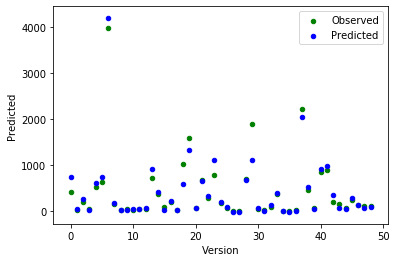

In [19]:
ax = results.plot(kind='scatter', x=c.VERSION, y=c.OBSERVED, c='green', label=c.OBSERVED)
results.plot(kind='scatter', x=c.VERSION, y=c.PREDICTED, c='blue', label=c.PREDICTED, ax=ax)

In [20]:
# partialRegPlot = plt.figure(figsize=(15,8))
# partialRegPlot = sm.graphics.regressionplots.plot_partregress_grid(model, fig=partialRegPlot)

In [21]:
# regPlotNC = plt.figure(figsize=(15,8))
# regPlotNC = sm.graphics.regressionplots.plot_regress_exog(model, c.NT_CC, fig=regPlotNC)

In [22]:
# regPlotNO = plt.figure(figsize=(15,8))
# regPlotNO = sm.graphics.regressionplots.plot_regress_exog(model, c.NO_CC, fig=regPlotNO)

In [23]:
# Predict using Random Forest
rf_regressor = RandomForestRegressor(n_estimators=300, random_state=0)
rf_regressor.fit(X_train,y_train)
y_pred_rf = rf_regressor.predict(X_test)

# #Cross validation (KFold method)
# y_pred_rf_cross = cross_val_predict(rf_regressor, X, Y, cv=10 )

# #Random Forest Regression Accuracy with cross validation
# accuracy_rf = metrics.r2_score(Y, y_pred_rf_cross)
# print('Cross-Predicted(KFold) Random Forest Regression Accuracy: ', accuracy_rf)

# print(classification_report(y_test, y_pred_rf))

In [24]:
data = {c.OBSERVED:y_test, c.PREDICTED:y_pred_rf.round(2), c.DIFFERENCE:abs(y_test - y_pred_rf).round(2), c.PERCENT_ERROR:(abs(y_test - y_pred_rf)/y_test).round(2)}
results = pd.DataFrame(data) 
results[c.VERSION] = np.arange(results.__len__())

In [25]:
rsquared = rf_regressor.score(X_test,y_test)
print("{0} - {1} - {2} model performance: ".format(project_name, task, c.MODULE_CC))
print(utils.format_perf_metric('Model - R Squared', rsquared))
print(utils.format_perf_metric('Model - R Squared Adj', utils.calculated_rsquared_adj(X, X_test, rsquared)))
print(utils.format_perf_metric('Pred - Mean Absolute Error', metrics.mean_absolute_error(y_test, y_pred_rf)))
print(utils.format_perf_metric('Pred - Mean Squared Error', metrics.mean_squared_error(y_test, y_pred_rf)))
print(utils.format_perf_metric('Pred - Root Mean Squared Error', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf))))
pred25 = utils.calculate_PRED(0.25, results)
print(utils.format_PRED("25", pred25))
pred50 = utils.calculate_PRED(0.50, results)
print(utils.format_PRED("50", pred50))

angular.js - BUG - Module_CC model performance: 
Model - R Squared: 0.92
Model - R Squared Adj: 0.91
Pred - Mean Absolute Error: 90.22
Pred - Mean Squared Error: 42118.27
Pred - Root Mean Squared Error: 205.23
Pred - PRED (25): 51.02%
Pred - PRED (50): 73.47%


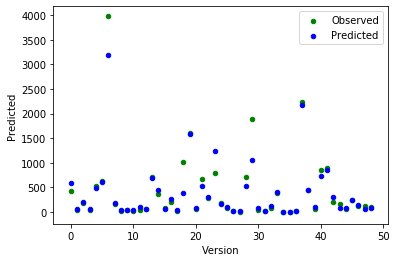

In [26]:
ax = results.plot(kind='scatter', x=c.VERSION, y=c.OBSERVED, c='green', label=c.OBSERVED)
results.plot(kind='scatter', x=c.VERSION, y=c.PREDICTED, c='blue', label=c.PREDICTED, ax=ax)

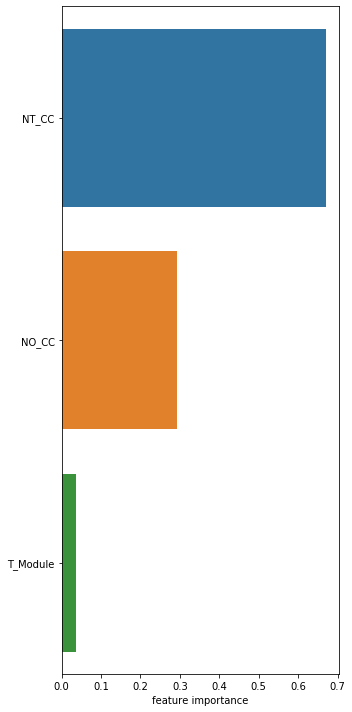

In [42]:
ranking = np.argsort(-rf_regressor.feature_importances_)
f, ax = plt.subplots(figsize=(5, 10))
sns.barplot(x=rf_regressor.feature_importances_[ranking], y=X_train.columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

In [28]:
NT = pd.Series(df[c.NT_CC], df.index)
NO = pd.Series(df[c.NO_CC], df.index)
T_Module = pd.Series(df[c.T_MODULE], df.index)

NT = NT.reset_index()
NT.columns = ['ds', 'y']

NO = NO.reset_index()
NO.columns = ['ds', 'y']

T_Module = T_Module.reset_index()
T_Module.columns = ['ds', 'y']

In [29]:
m_NT = Prophet(interval_width=0.90)
m_NT.fit(NT)

m_NO = Prophet(interval_width=0.90)
m_NO.fit(NO)

m_T_Module = Prophet(interval_width=0.90)
m_T_Module.fit(T_Module)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [30]:
future_NT = m_NT.make_future_dataframe(periods=36, freq='m')
forecast_NT = m_NT.predict(future_NT)
forecast_NT[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
227,2022-06-30,100.908461,-230.546386,442.438910
228,2022-07-31,451.069121,128.891788,766.947258
229,2022-08-31,371.749782,43.910258,709.676072
230,2022-09-30,416.446308,70.643939,705.086500
231,2022-10-31,85.576495,-262.809005,406.160704


In [31]:
future_NO = m_NO.make_future_dataframe(periods=36, freq='m')
forecast_NO = m_NO.predict(future_NO)
forecast_NO[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
227,2022-06-30,204.402655,-509.660458,862.817914
228,2022-07-31,798.282436,168.032254,1473.442025
229,2022-08-31,706.873364,61.106800,1332.362291
230,2022-09-30,955.037387,268.715222,1586.010699
231,2022-10-31,198.098383,-489.534947,858.154725


In [32]:
future_T_Module = m_T_Module.make_future_dataframe(periods=36, freq='m')
forecast_T_Module= m_T_Module.predict(future_T_Module)
forecast_T_Module[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
227,2022-06-30,1963.869032,1740.366341,2184.278606
228,2022-07-31,1964.174671,1768.776495,2178.239445
229,2022-08-31,2019.647681,1813.508796,2220.551287
230,2022-09-30,2069.873951,1856.547951,2289.127415
231,2022-10-31,2147.419492,1919.680331,2382.949304


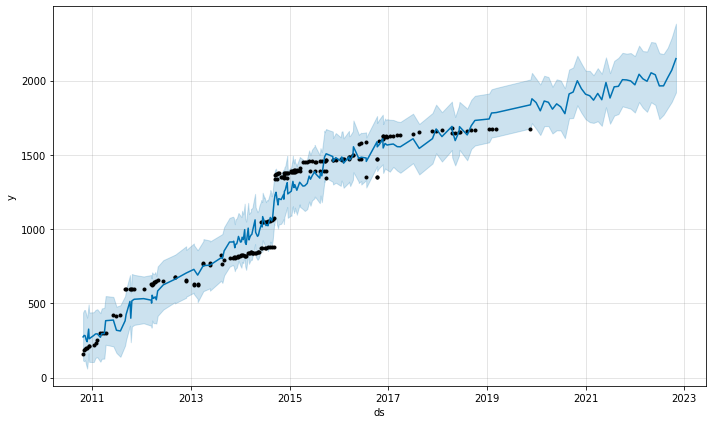

In [33]:
fig_T_Module = m_T_Module.plot(forecast_T_Module)

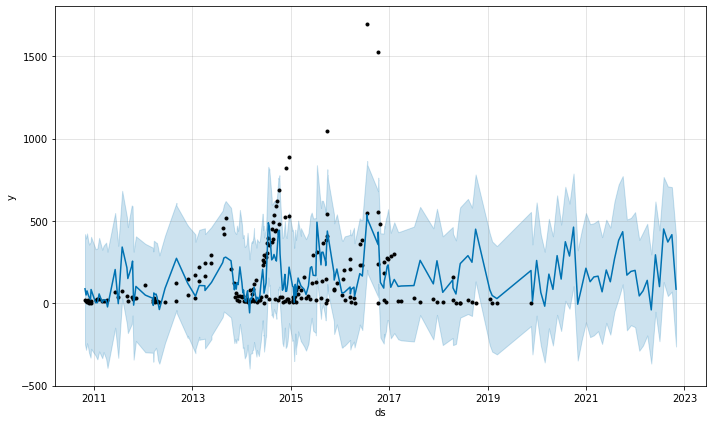

In [34]:
fig_NT = m_NT.plot(forecast_NT)

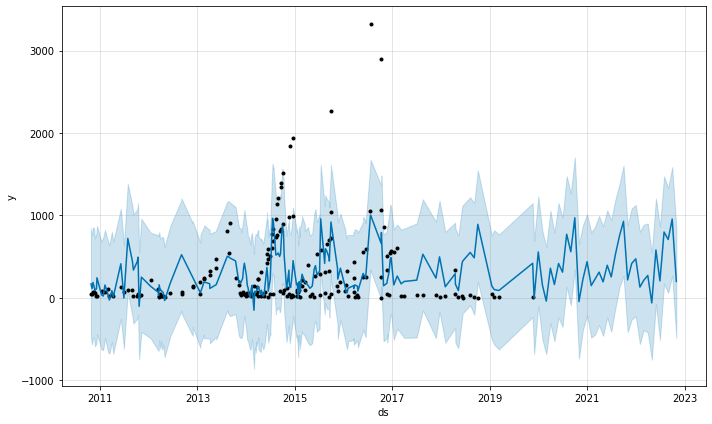

In [35]:
fig_NO = m_NO.plot(forecast_NO)

In [39]:
data = {
    c.NT_CC: forecast_NT['yhat'],
    c.NO_CC: forecast_NO['yhat'],
    c.T_MODULE: forecast_T_Module['yhat']
}

X_Future = pd.DataFrame(data) 
y_pred_rf = rf_regressor.predict(X_Future)
y_pred_index = forecast_NT['ds']

In [40]:
data = {c.MODULE_CC : y_pred_rf.round(2), c.VERSION: y_pred_index}
results = pd.DataFrame(data) 
# results[c.VERSION] = np.arange(results.__len__())

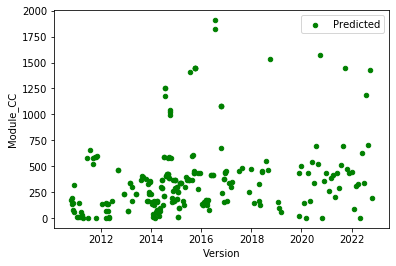

In [41]:
ax = results.plot(kind='scatter', x=c.VERSION, y=c.MODULE_CC, c='green', label=c.PREDICTED)